# 02 — Tabular Baseline Models (ADNI)

## Overview
This notebook trains baseline machine learning models using **clinical + demographic features** from the ADNI dataset to classify diagnostic status:
- **CN** (Cognitively Normal)
- **MCI** (Mild Cognitive Impairment / EMCI)
- **AD** (Alzheimer's Disease)

### Models
- **Logistic Regression** - Linear baseline model
- **Random Forest** - Non-linear ensemble model

### Interpretation
We use **SHAP (SHapley Additive exPlanations)** to interpret model predictions and understand feature contributions to classification decisions.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import shap
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

/Users/Home/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Explore ADNI Data

In [2]:
# Load processed ADNI data
data_path = Path("../data/processed/adni_baseline_tabular.csv")
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\n" + "="*60)
print("Dataset Information")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"\nDiagnosis distribution:")
print(df['DX.bl'].value_counts())

print("\n" + "="*60)
print("Feature Statistics")
print("="*60)
print(df.describe())

Dataset Shape: (494, 11)

First few rows:
   RID VISCODE  EXAMDATE DX.bl   AGE PTGENDER  PTEDUCAT  APOE4  MMSE  \
0    5      bl    9/7/05    CN  73.7     Male        16      0    29   
1   31      bl  10/24/05    CN  77.7   Female        18      0    30   
2   35      bl   11/8/05    CN  76.9     Male        18      0    30   
3   43      bl    2/3/06    CN  76.2     Male        16      0    29   
4   47      bl  12/15/05    CN  84.7     Male        20      0    30   

  APOE Genotype  GENDER  
0           3,3       1  
1           3,3       0  
2           3,3       1  
3           2,3       1  
4           2,3       1  

Dataset Information
Total samples: 494

Diagnosis distribution:
DX.bl
CN      241
EMCI    130
AD      123
Name: count, dtype: int64

Feature Statistics
               RID         AGE    PTEDUCAT       APOE4        MMSE      GENDER
count   494.000000  494.000000  494.000000  494.000000  494.000000  494.000000
mean   2035.000000   74.510526   15.937247    0.489879   2

## 2. Prepare Features and Target Variable

In [7]:
# Define clinical and demographic features (numerical only for model compatibility)
features = ["AGE", "GENDER", "PTEDUCAT", "MMSE", "APOE4"]
target = "DX.bl"

# Verify no missing values
print("Missing values per feature:")
print(df[features + [target]].isnull().sum())

# Prepare X (features) and y (target)
X = df[features].copy()
y = df[target].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nTarget classes: {y.unique()}")
print(f"\nClass distribution:")
print(y.value_counts())

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n" + "="*60)
print("Train-Test Split")
print("="*60)
print(f"Training set size: {X_train.shape[0]} ({100*X_train.shape[0]/len(X):.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({100*X_test.shape[0]/len(X):.1f}%)")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Missing values per feature:
AGE         0
GENDER      0
PTEDUCAT    0
MMSE        0
APOE4       0
DX.bl       0
dtype: int64

Feature matrix shape: (494, 5)
Target variable shape: (494,)

Target classes: ['CN' 'AD' 'EMCI']

Class distribution:
DX.bl
CN      241
EMCI    130
AD      123
Name: count, dtype: int64

Train-Test Split
Training set size: 395 (80.0%)
Test set size: 99 (20.0%)

Training set class distribution:
DX.bl
CN      193
EMCI    104
AD       98
Name: count, dtype: int64

Test set class distribution:
DX.bl
CN      48
EMCI    26
AD      25
Name: count, dtype: int64


## 3. Train Logistic Regression Model

Training Logistic Regression...

Logistic Regression Performance
Accuracy:  0.7576
Precision: 0.7482
Recall:    0.7576
F1-Score:  0.7298

Confusion Matrix:
[[23  1  1]
 [ 1 44  3]
 [ 2 16  8]]

Classification Report:
              precision    recall  f1-score   support

          AD       0.88      0.92      0.90        25
          CN       0.72      0.92      0.81        48
        EMCI       0.67      0.31      0.42        26

    accuracy                           0.76        99
   macro avg       0.76      0.71      0.71        99
weighted avg       0.75      0.76      0.73        99



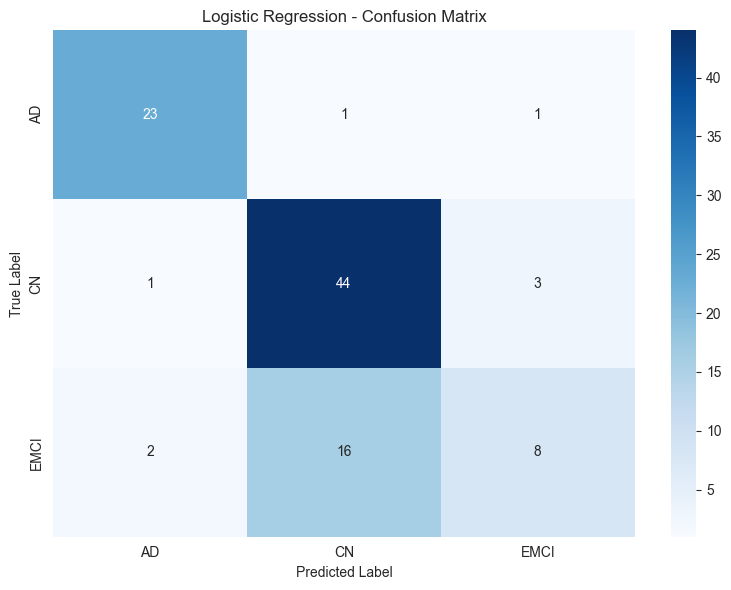

In [8]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)

# Evaluation metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)

print("\n" + "="*60)
print("Logistic Regression Performance")
print("="*60)
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {recall_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_, 
            yticklabels=lr_model.classes_, ax=ax)
ax.set_title("Logistic Regression - Confusion Matrix")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## 4. Train Random Forest Model

Training Random Forest...

Random Forest Performance
Accuracy:  0.7778
Precision: 0.7638
Recall:    0.7778
F1-Score:  0.7577

Confusion Matrix:
[[24  0  1]
 [ 1 43  4]
 [ 3 13 10]]

Classification Report:
              precision    recall  f1-score   support

          AD       0.86      0.96      0.91        25
          CN       0.77      0.90      0.83        48
        EMCI       0.67      0.38      0.49        26

    accuracy                           0.78        99
   macro avg       0.76      0.75      0.74        99
weighted avg       0.76      0.78      0.76        99



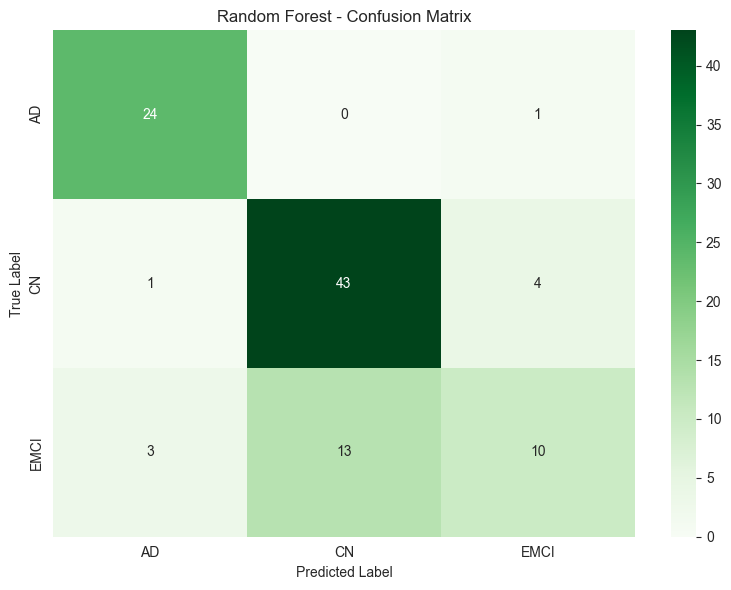

In [9]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluation metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

print("\n" + "="*60)
print("Random Forest Performance")
print("="*60)
print(f"Accuracy:  {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=rf_model.classes_, 
            yticklabels=rf_model.classes_, ax=ax)
ax.set_title("Random Forest - Confusion Matrix")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## 5. Compare Model Performance


Model Performance Comparison
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.757576   0.748199 0.757576  0.729785
      Random Forest  0.777778   0.763829 0.777778  0.757745


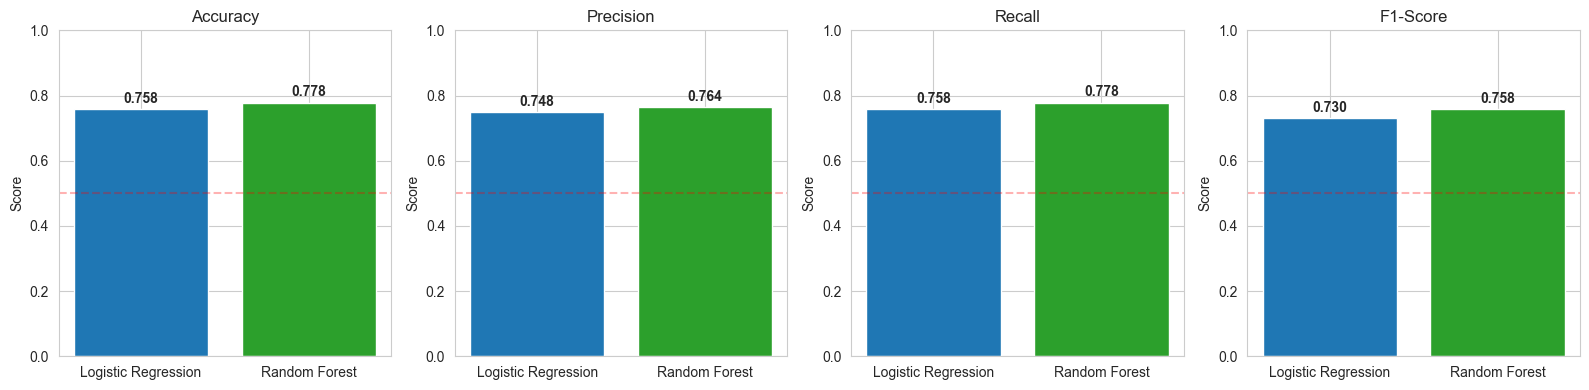


Summary
Best model (F1-Score): Random Forest


In [16]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_lr, acc_rf],
    'Precision': [prec_lr, prec_rf],
    'Recall': [recall_lr, recall_rf],
    'F1-Score': [f1_lr, f1_rf]
})

print("\n" + "="*60)
print("Model Performance Comparison")
print("="*60)
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=['#1f77b4', '#2ca02c'])
    axes[idx].set_title(metric)
    axes[idx].set_ylabel('Score')
    axes[idx].set_ylim([0, 1])
    axes[idx].axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
    for i, v in enumerate(comparison_df[metric]):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Highlight best model
print("\n" + "="*60)
print("Summary")
print("="*60)
best_f1_idx = comparison_df['F1-Score'].idxmax()
print(f"Best model (F1-Score): {comparison_df.loc[best_f1_idx, 'Model']}")

## 6. Generate SHAP Explanations for Logistic Regression

Computing SHAP values for Logistic Regression...
SHAP values shape: (99, 5, 3)

Logistic Regression - SHAP Feature Importance (Summary Plot)


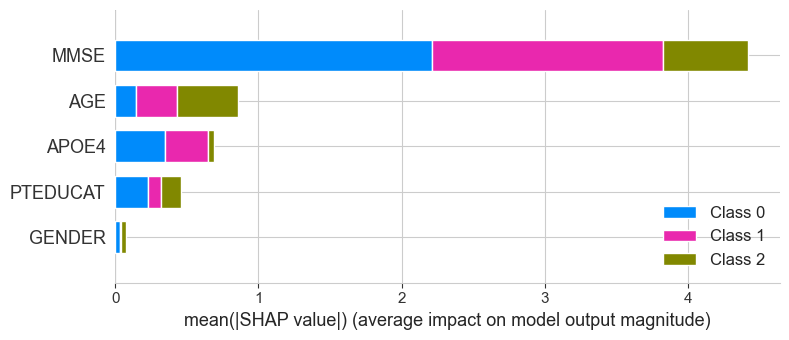

In [12]:
# Initialize SHAP explainer for Logistic Regression
print("Computing SHAP values for Logistic Regression...")
# Use a simpler approach: LinearExplainer for logistic regression
explainer_lr = shap.LinearExplainer(lr_model, X_train, check_additivity=False)
shap_values_lr = explainer_lr.shap_values(X_test)

# Handle multi-class case
if isinstance(shap_values_lr, list):
    print(f"SHAP values: {len(shap_values_lr)} classes")
    for i, class_name in enumerate(lr_model.classes_):
        print(f"  {class_name}: {shap_values_lr[i].shape}")
else:
    print(f"SHAP values shape: {shap_values_lr.shape}")

# Summary plot
print("\n" + "="*60)
print("Logistic Regression - SHAP Feature Importance (Summary Plot)")
print("="*60)

if isinstance(shap_values_lr, list):
    for i, class_name in enumerate(lr_model.classes_):
        plt.figure()
        shap.summary_plot(shap_values_lr[i], X_test, plot_type="bar", 
                          title=f"SHAP Feature Importance - {class_name}", show=False)
        plt.tight_layout()
        plt.show()
else:
    plt.figure()
    shap.summary_plot(shap_values_lr, X_test, plot_type="bar", 
                      title="SHAP Feature Importance", show=False)
    plt.tight_layout()
    plt.show()

## 7. Generate SHAP Explanations for Random Forest

Computing SHAP values for Random Forest...
SHAP values shape: (99, 5, 3)

Random Forest - SHAP Feature Importance (Summary Plot)


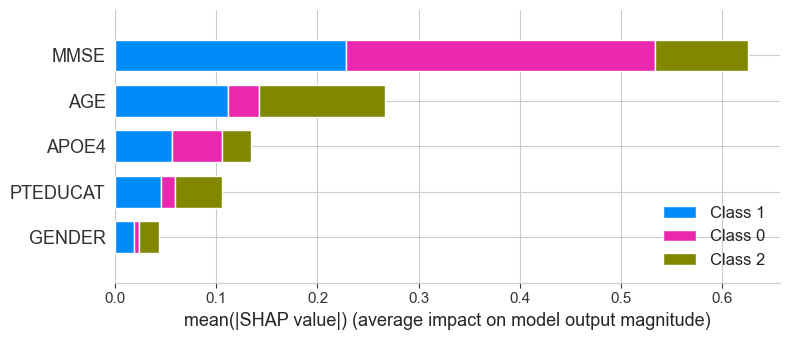

In [13]:
# Initialize SHAP explainer for Random Forest
print("Computing SHAP values for Random Forest...")
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Handle multi-class case
if isinstance(shap_values_rf, list):
    print(f"SHAP values: {len(shap_values_rf)} classes")
    for i, class_name in enumerate(rf_model.classes_):
        print(f"  {class_name}: {shap_values_rf[i].shape}")
else:
    print(f"SHAP values shape: {shap_values_rf.shape}")

# Summary plot for each class
print("\n" + "="*60)
print("Random Forest - SHAP Feature Importance (Summary Plot)")
print("="*60)

if isinstance(shap_values_rf, list):
    for i, class_name in enumerate(rf_model.classes_):
        plt.figure()
        shap.summary_plot(shap_values_rf[i], X_test, plot_type="bar",
                          title=f"SHAP Feature Importance - {class_name}", show=False)
        plt.tight_layout()
        plt.show()
else:
    plt.figure()
    shap.summary_plot(shap_values_rf, X_test, plot_type="bar",
                      title="SHAP Feature Importance", show=False)
    plt.tight_layout()
    plt.show()

## 8. Visualize Feature Importance with SHAP


Logistic Regression - SHAP Feature Importance


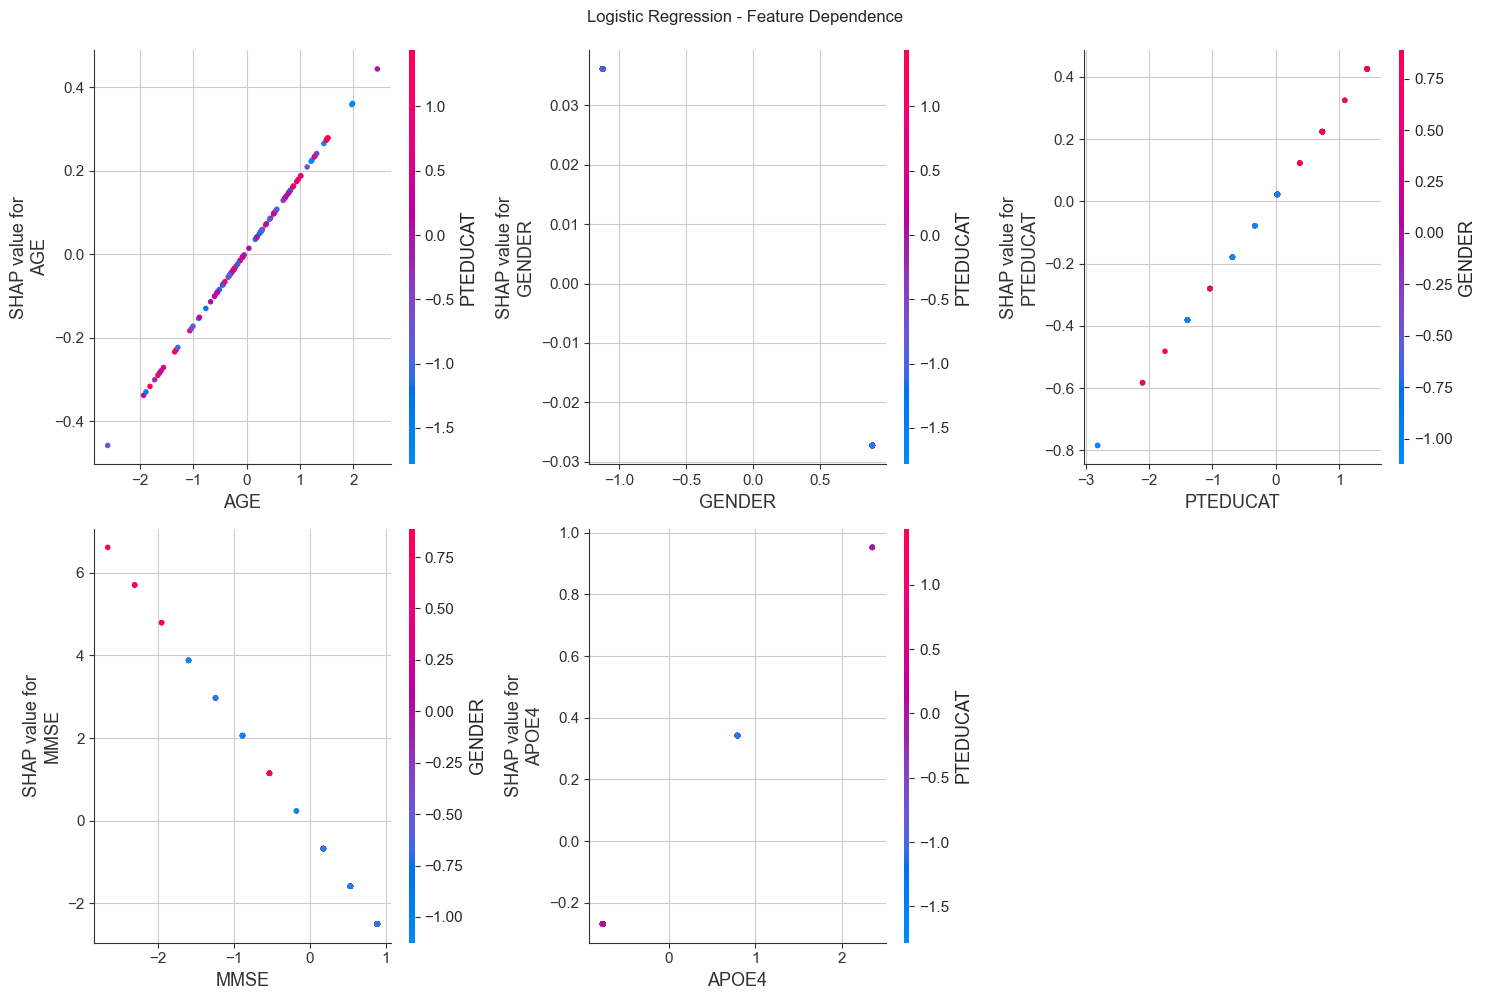


Random Forest - SHAP Feature Importance


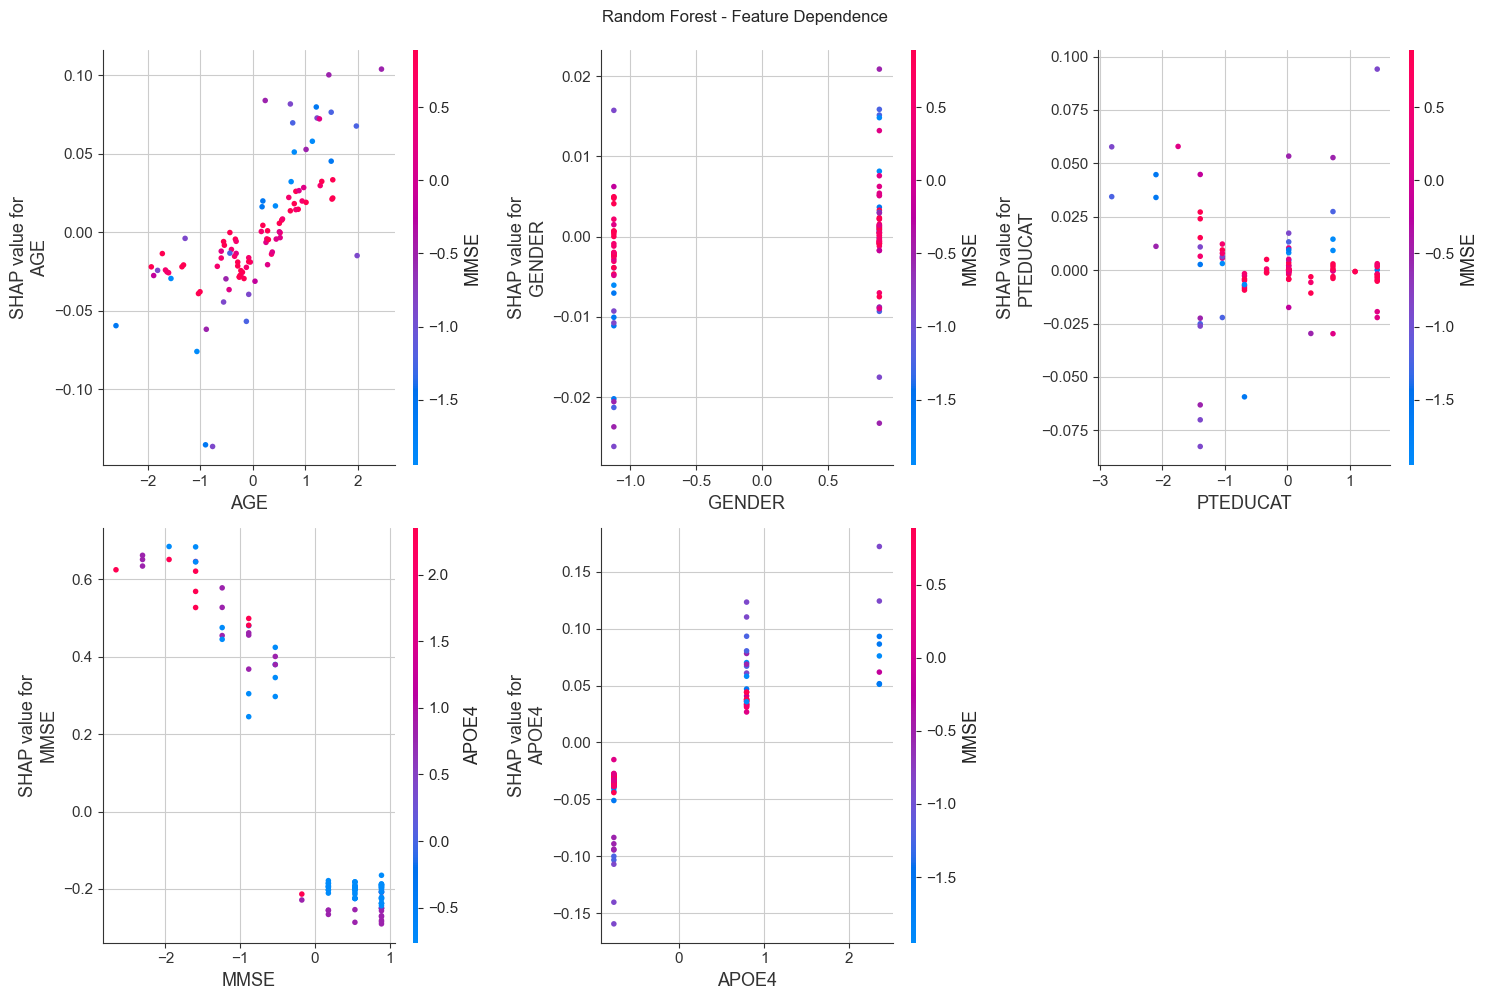


✓ Analysis Complete


In [15]:
# SHAP Dependence Plots - Logistic Regression
print("\n" + "="*60)
print("Logistic Regression - SHAP Feature Importance")
print("="*60)

# Extract SHAP values - handle both 2D and 3D cases
if len(shap_values_lr.shape) == 3:
    # Multi-class: shape is (n_samples, n_features, n_classes)
    # Take the class 0 (AD) for visualization
    shap_lr_2d = shap_values_lr[:, :, 0]
else:
    shap_lr_2d = shap_values_lr

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes_flat = axes.flatten()

for idx, feature in enumerate(features):
    shap.dependence_plot(idx, shap_lr_2d, X_test, 
                         feature_names=features, ax=axes_flat[idx], show=False)

# Hide the extra unused subplot
axes_flat[-1].set_visible(False)

plt.suptitle("Logistic Regression - Feature Dependence", y=0.995)
plt.tight_layout()
plt.show()

# SHAP Dependence Plots - Random Forest
print("\n" + "="*60)
print("Random Forest - SHAP Feature Importance")
print("="*60)

# Extract SHAP values - handle both 2D and 3D cases
if len(shap_values_rf.shape) == 3:
    # Multi-class: shape is (n_samples, n_features, n_classes)
    # Take the class 0 (AD) for visualization
    shap_rf_2d = shap_values_rf[:, :, 0]
else:
    shap_rf_2d = shap_values_rf

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes_flat = axes.flatten()

for idx, feature in enumerate(features):
    shap.dependence_plot(idx, shap_rf_2d, X_test, 
                         feature_names=features, ax=axes_flat[idx], show=False)

# Hide the extra unused subplot
axes_flat[-1].set_visible(False)

plt.suptitle("Random Forest - Feature Dependence", y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ Analysis Complete")
print("="*60)